# Working Demo - Species Classification model
This notebook contains a working demo with a small sample of files from the original dataset

In [21]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import os 
 
os.chdir('/Users/jessicakahn/Documents/Harvard DL/final_project/Species Demo') 
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /Users/jessicakahn/Documents/Harvard DL/final_project/Species Demo


In [4]:
!unzip *.zip

In [7]:
# Read in the whale IDs of each image
train_ids = pd.read_csv('train.csv')

In [10]:
# Join image filenames to whale IDs
train_dir = 'species_sample_files/'
im_list = os.listdir(train_dir)
train_df = pd.DataFrame(im_list, columns=['image'])
train_df = train_df.merge(train_ids, on='image', how='left')
train_df["image_path"] = train_df["image"].apply(lambda x: train_dir  + x)

In [11]:
# Check image_path is correct
train_df.head(2)

,image,species,individual_id,image_path
0,e0284f7155eaec.jpg,dusky_dolphin,e6ca72d90937,species_sample_files/e0284f7155eaec.jpg
1,b292f8b5c714f7.jpg,spinner_dolphin,8dfb5b2da757,species_sample_files/b292f8b5c714f7.jpg
2,cb427eafeb8468.jpg,rough_toothed_dolphin,c367e1417e83,species_sample_files/cb427eafeb8468.jpg
3,96c6183f770f6a.jpg,southern_right_whale,400a9d3b7750,species_sample_files/96c6183f770f6a.jpg
4,abfc3a269dd65d.jpg,spinner_dolphin,0955678d2d25,species_sample_files/abfc3a269dd65d.jpg


### Make folders for each species
Because Keras' flow_from_directory requires one folder per class, this helper function will 
create a folder for each species with the images inside

In [12]:
from pathlib import Path

def make_folders(path):
    """
    This function creates separate folders for each unique id,
    which will have 1 or more images per folder
    """
    mappings = train_df.groupby('species')['image'].apply(list).to_dict()
    for folder, file_list in mappings.items():
        for imfile in file_list:
            imfile = Path(path.joinpath(imfile))
            Path(path.joinpath(folder)).mkdir(parents=True, exist_ok=True)
            path = Path(path.joinpath())
            try:
                imfile.rename(path / folder / imfile.name)
            except FileNotFoundError:
                print(f"Couldn't find {imfile.stem} in source folder")

In [13]:
train_path = Path(train_dir)
make_folders(train_path)

In [14]:
def plot_history(history, nepochs, metric):
    """ Helper function to plot accuracy or loss after model training """
    train_acc = history.history[metric]
    test_acc = history.history['val_'+metric]

    plt.figure(figsize=(16,6))
    plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
    plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")

    #plt.ylim((0, 0.0001))
    plt.title('CNN: max(val_{}) = '.format(metric) + str(round(max(test_acc),6)),fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc = 'upper right',fontsize=16)
    # plt.ylim(0,0.06)

    plt.show()

In [17]:
# We are going to add some augmentation to our images and use ImageDataGenerator
train_datagen = ImageDataGenerator(
                                # preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%


train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(128, 128), 
                                            #    color_mode='rgb',
                                               batch_size=32, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = train_datagen.flow_from_directory(train_dir, 
                                           target_size=(128, 128), 
                                        #    color_mode='rgb',
                                           batch_size=32, 
                                           class_mode='categorical',
                                           shuffle=True,
                                           subset = 'validation')

Found 239 images belonging to 30 classes.
Found 56 images belonging to 30 classes.


In [18]:
# Build species model architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), strides = (1, 1), input_shape = (128, 128, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(filters=64, kernel_size = (3, 3), strides = (1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(30, activation='softmax')) # Number of species

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 61, 61, 64)        0

### Fit the Model
Due to the small dataset size, we don't expect optimal accuracy from this

In [19]:
n = 100
history = model.fit(
      train_data,
      # steps_per_epoch=100,
      epochs=n,
      validation_data=val_data
      # ,validation_steps=50
      )

Epoch 1/100
8/8 [==============================] - 6s 629ms/step - loss: 9.0024 - accuracy: 0.0460 - val_loss: 3.4259 - val_accuracy: 0.0357
Epoch 2/100
8/8 [==============================] - 5s 594ms/step - loss: 3.4329 - accuracy: 0.0753 - val_loss: 3.4018 - val_accuracy: 0.0357
Epoch 3/100
8/8 [==============================] - 6s 760ms/step - loss: 3.3968 - accuracy: 0.0460 - val_loss: 3.4020 - val_accuracy: 0.0714
Epoch 4/100
8/8 [==============================] - 4s 522ms/step - loss: 3.3668 - accuracy: 0.0669 - val_loss: 3.4092 - val_accuracy: 0.0357
Epoch 5/100
8/8 [==============================] - 4s 531ms/step - loss: 3.3539 - accuracy: 0.0377 - val_loss: 3.4119 - val_accuracy: 0.0179
Epoch 6/100
8/8 [==============================] - 5s 537ms/step - loss: 3.3458 - accuracy: 0.0502 - val_loss: 3.3939 - val_accuracy: 0.0357
Epoch 7/100
8/8 [==============================] - 5s 611ms/step - loss: 3.3021 - accuracy: 0.0669 - val_loss: 3.3985 - val_accuracy: 0.0714
Epoch 8/100
8

/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_32704/1920935807.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_32704/1920935807.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")


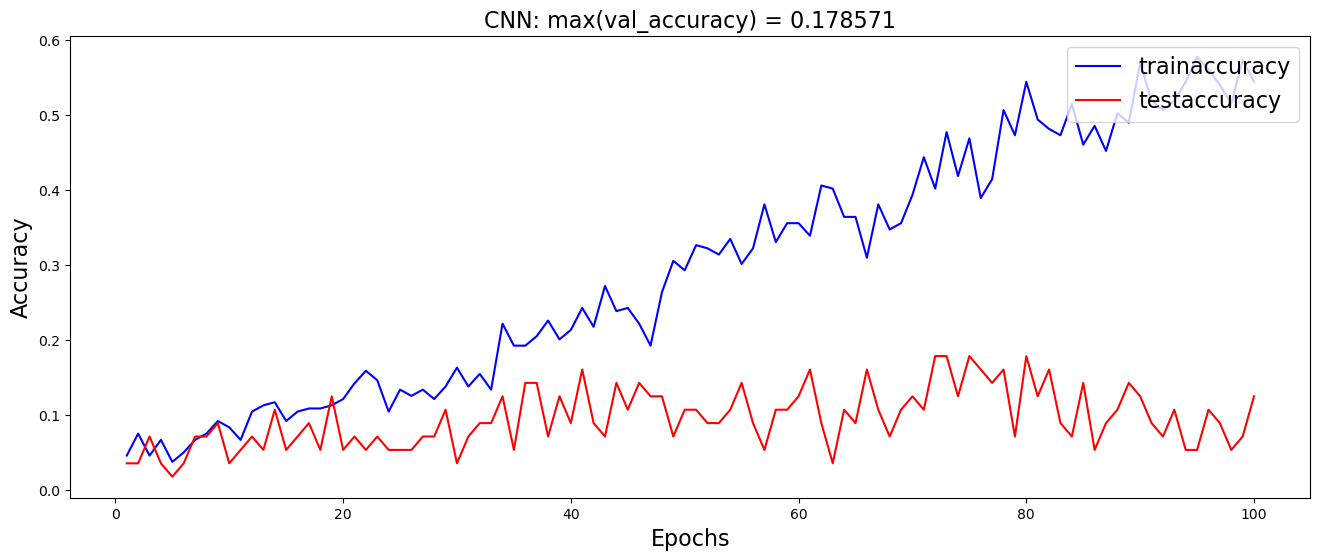

In [22]:
plot_history(history, n, 'accuracy')

In [23]:
predictions = model.predict(val_data)

2/2 [==============================] - 1s 183ms/step


In [24]:
results = model.evaluate(val_data, verbose = 0)
pred = np.argmax(model.predict(val_data), axis = 1)
class_names = list(val_data.class_indices.keys())
cm = confusion_matrix(val_data.labels, pred, labels = np.arange(30))
clr = classification_report(val_data.labels, pred, labels = np.arange(30),target_names = class_names)

2/2 [==============================] - 0s 159ms/step


/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jessicakahn/miniconda3/envs/Assignment1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Text(0.5, 1.0, 'Confusion matrix')

<Figure size 2500x2500 with 0 Axes>

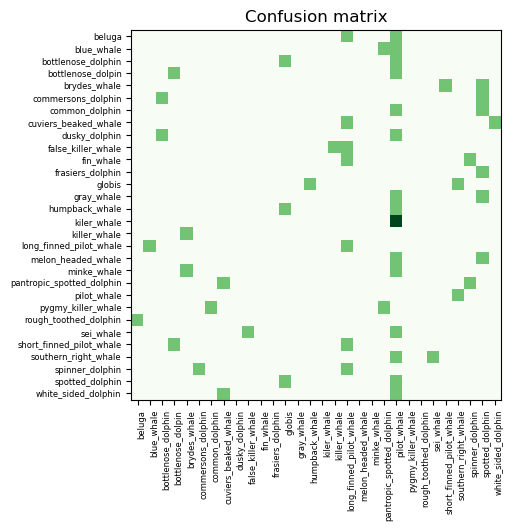

In [25]:
plt.figure(figsize=(25,25))
fig, ax = plt.subplots()
im = ax.imshow(cm,cmap='Greens', interpolation='nearest')
ax = plt.gca();

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(30), labels=class_names, fontsize=6)
ax.set_yticks(np.arange(30), labels=class_names,fontsize=6)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation='vertical', ha="right",
         rotation_mode="anchor")

ax.grid(which='minor', color='yellow', linestyle='-', linewidth=2)
ax.set_title("Confusion matrix")
# ax.cbar_axes[1].colorbar(im)
# colorbar()
# fig.tight_layout()
# plt.show()